In [2]:
from os import listdir
from tqdm import tqdm
import xml.etree.ElementTree as ET

# import modules & set up logging
import numpy as np
from gensim.corpora import Dictionary
from gensim.parsing.preprocessing import remove_stopwords

# Load word2vec pre-train model
import gensim.downloader as api
import gensim.models.keyedvectors as word2vec
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
"""from google.colab import drive
drive.mount('/content/drive')"""

"from google.colab import drive\ndrive.mount('/content/drive')"

## Get all the sentences (text) and the correspondent entailments (hypothesis) from the dataset

In [3]:
DS_PATH = "dataset/rteFormatData"
#DS_PATH = "/content/drive/MyDrive/Colab Notebooks/ENTAILMENT_GRAPH_ENG_V2.0/data/ENTAILMENT_GRAPH_RTE_FORMAT_ENG_V2.0/rteFormatData"

In [4]:
files = [f for f in listdir(DS_PATH)]
trees = []
entailment_pairs = []
sentences = []

for file in files:
    trees.append(ET.parse(DS_PATH+'/'+file))

for tree in trees:
    root = tree.getroot()
    for pair in root.findall('pair'):
        if pair.attrib['entailment'] == 'ENTAILMENT':
            text = pair.find('t').text.lower()
            hypothesis = pair.find('h').text.lower()
            sentences.append(text)
            sentences.append(hypothesis)
            entailment_pairs.append((text, hypothesis))

# Remove duplicates
entailment_pairs = list(set([i for i in entailment_pairs]))

## Get dataset to train the Casual Language Model

In [5]:
#!pip install datasets

In [6]:
from datasets import load_dataset
datasets = load_dataset('wikitext', 'wikitext-2-raw-v1')

Reusing dataset wikitext (C:\Users\aless\.cache\huggingface\datasets\wikitext\wikitext-2-raw-v1\1.0.0\a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126)
100%|██████████| 3/3 [00:00<00:00, 136.88it/s]


In [7]:
import string

def group_texts(examples):
    text = ''
    for entry in examples:
        text += ' ' + entry['text']  
    return text
 
# turn a doc into clean tokens
def clean_doc(doc):
	# replace '--' with a space ' '
	doc = doc.replace('--', ' ')
	# split into tokens by white space
	tokens = doc.split()
	# remove punctuation from each token
	table = str.maketrans('', '', string.punctuation)
	tokens = [w.translate(table) for w in tokens]
	# remove remaining tokens that are not alphabetic
	tokens = [word for word in tokens if word.isalpha()]
	# make lower case
	tokens = [word.lower() for word in tokens]
	return tokens

In [8]:
text = group_texts(datasets['train'])

In [86]:
text[:100]

'   = Valkyria Chronicles III = \n   Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュ'

In [10]:
c_doc = clean_doc(text)

In [87]:
print(c_doc[:100])

['valkyria', 'chronicles', 'iii', 'senjō', 'no', 'valkyria', 'unrecorded', 'chronicles', 'japanese', 'lit', 'valkyria', 'of', 'the', 'battlefield', 'commonly', 'referred', 'to', 'as', 'valkyria', 'chronicles', 'iii', 'outside', 'japan', 'is', 'a', 'tactical', 'role', 'playing', 'video', 'game', 'developed', 'by', 'sega', 'and', 'mediavision', 'for', 'the', 'playstation', 'portable', 'released', 'in', 'january', 'in', 'japan', 'it', 'is', 'the', 'third', 'game', 'in', 'the', 'valkyria', 'series', 'employing', 'the', 'same', 'fusion', 'of', 'tactical', 'and', 'real', 'time', 'gameplay', 'as', 'its', 'predecessors', 'the', 'story', 'runs', 'parallel', 'to', 'the', 'first', 'game', 'and', 'follows', 'the', 'nameless', 'a', 'penal', 'military', 'unit', 'serving', 'the', 'nation', 'of', 'gallia', 'during', 'the', 'second', 'europan', 'war', 'who', 'perform', 'secret', 'black', 'operations', 'and', 'are', 'pitted']


In [12]:
#datasets['train'][300]['text']

## Load a pre-trained embedding model for evaluation

In [12]:
#PATH = api.load("word2vec-google-news-300", return_path=True)
PATH = "dataset/word2vec-google-news-300\word2vec-google-news-300.gz"
#PATH = "drive/MyDrive/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz"
gn_model = word2vec.KeyedVectors.load_word2vec_format(PATH, binary=True)
#weights = torch.FloatTensor(gn_model.wv.vectors)

# Training Sets

## Generate vocabulary

In [13]:
V = Dictionary([['<PAD>']])
V.add_documents([c_doc])

for sentence in sentences:
    V.add_documents([sentence.split()])

In [14]:
def training_sequence(seq, dictionary):
    idxs = dictionary.doc2idx(seq)
    # remove unknown tokens
    if -1 in idxs: idxs.remove(-1)
    return torch.tensor(idxs, dtype=torch.long)

## Casual training set preprocessing

In [84]:
def build_casual_ds(clean_text, sentence_len=2):
    X = []
    y = []

    for idx in tqdm(range(len(clean_text) - sentence_len - 1)):
        X.append(training_sequence(clean_text[idx:idx+sentence_len], V))
        y.append(training_sequence(clean_text[idx+1:idx+1+sentence_len], V))
        
    X = torch.stack(X_c)
    y = torch.stack(y_c)

    return X, y

In [85]:
X_c, y_c = build_casual_ds(c_doc, 5)

 17%|█▋        | 292196/1683470 [00:17<01:21, 17018.49it/s]


KeyboardInterrupt: 

## Tuning training set preprocessing

In [16]:
max_sentence_size = 0

for sentence in sentences:
    l = len(sentence.lower().split())
    if l > max_sentence_size:
        max_sentence_size = l

In [17]:
def build_tuning_ts(entailment_pairs):
    X = []
    y = []

    for text, hypothesis in entailment_pairs:
        text = text.lower().split()
        hypothesis = hypothesis.lower().split()
      
        if len(text) < max_sentence_size:
            text = text + ['<PAD>'] * (max_sentence_size-len(text))
        
        if len(hypothesis) < max_sentence_size:
            hypothesis = hypothesis + ['<PAD>'] * (max_sentence_size-len(hypothesis))
        
        X.append(training_sequence(text, V))
        y.append(training_sequence(hypothesis, V))

    X = torch.stack(X)
    y = torch.stack(y)
    return X, y

In [18]:
X_t, y_t = build_tuning_ts(entailment_pairs)

## LSTM model

In [19]:
class LSTMlm(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, target_size):
        super(LSTMlm, self).__init__()
        self.hidden_dim = hidden_dim
        self.target_size = target_size
        self.num_layers = 3
        self.word_embeddings = nn.Embedding(vocab_size, 
                                            embedding_dim, 
                                            padding_idx=0
                                            )

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(input_size=embedding_dim, 
                            hidden_size=self.hidden_dim, 
                            num_layers=self.num_layers,
                            dropout=0.2,
                            batch_first=False
                            )

        # The linear layer that maps from hidden state space to target space
        self.hidden2tag = nn.Linear(self.hidden_dim, target_size)

    def forward(self, X, X_lengths=[], padding=False):
        batch_size, seq_len= X.size()

        # ---------------------
        # 1. embed the input
        # Dim transformation: (batch_size, seq_len, 1) -> (batch_size, seq_len, embedding_dim)
        X = self.word_embeddings(X)

        # ---------------------
        # 2. Run through RNN

        # pack_padded_sequence so that padded items in the sequence won't be shown to the LSTM
        if padding:X = torch.nn.utils.rnn.pack_padded_sequence(X, X_lengths, batch_first=True)
        
        # run through LSTM
        X, _ = self.lstm(X)
        

        # undo the packing operation
        if padding:X, _ = torch.nn.utils.rnn.pad_packed_sequence(X, batch_first=True)
        
        # ---------------------
        # 3. Project to tag space

        # first we need to reshape the data so it goes into the linear layer
        X = X.contiguous()
        X = X.view(-1, X.shape[2])

        # run through actual linear layer
        X = self.hidden2tag(X)

        y_hat = F.log_softmax(X, dim=1)
        
        # reshape back to (batch_size, seq_len, target_size)
        y_hat = X.view(batch_size, seq_len, -1)

        return y_hat

## Model training

In [20]:
def evaluation_sequence(seq, dictionary):
    return [dictionary[token] for token in seq if token in dictionary.key_to_index]

In [21]:
def compute_cos_sim(sentence1, sentence2):
    sentence1 = remove_stopwords(sentence1)
    sentence2 = remove_stopwords(sentence2)
    sentence1 = torch.Tensor(np.array(evaluation_sequence(sentence1.split(), gn_model))).mean(dim=0)
    sentence2 = torch.Tensor(np.array(evaluation_sequence(sentence2.split(), gn_model))).mean(dim=0)
    output = F.cosine_similarity(sentence1, sentence2, dim=0)
    return output

In [22]:
def listToString(myList, dictionary=None):
    if dictionary != None:
        myList = [V[x] for x in myList]
    answer = ""
    for token in myList:
        answer += token + " "
    return answer

In [23]:
def sentence2sentence(sentence):
    model.eval()
    sentence = sentence.split()
    sequence = training_sequence(sentence, V)

    answer_l = []
    tensor = model(sequence.view(1, -1))
    idxs = torch.argmax(tensor, dim=2).flatten().tolist()
    answer_l = [V[v] for v in idxs]

    answer = ""
    for token in answer_l:
        #if word != "<PAD>":
        answer += token + " "

    return answer

In [26]:
"""import math

def evaluate_model(entailment_pairs):
    cos_sim = []
    n_nan = 0
    text_target_answer = apply_model(entailment_pairs)
    for tri in text_target_answer:
        _, target, answer = tri
        output = compute_cos_sim(target,answer)
        if (math.isnan(output)):
            n_nan += 1
        else:
            cos_sim.append(output)
            
    mean_cos_sim = sum(cos_sim) / len(cos_sim)
    return mean_cos_sim, n_nan"""

In [24]:
def predict(dataset, model, text, next_words=100):
    model.eval()

    words = text.split(' ')

    for i in range(0, next_words):
        x = torch.tensor([[dataset.token2id[w] for w in words[i:]]])
        y_pred = model(x)

        last_word_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_word_logits, dim=0).detach().numpy()
        word_index = np.random.choice(len(last_word_logits), p=p)
        words.append(dataset.id2token[word_index])

    return words

In [52]:
EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TARGET_SIZE = 100, 64, len(V), len(V)
model = LSTMlm(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TARGET_SIZE)
loss_function = nn.NLLLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Casual Language Model Training

In [53]:
N_EPOCHS = 10
N_SAMPLES = 1000
BATCH_SIZE = 100
casual_model_loss = []

STRIDE = 100000

X = X_c[STRIDE:N_SAMPLES+STRIDE]
y = y_c[STRIDE:N_SAMPLES+STRIDE]

# split dataset into batches
X = [X[i:i + BATCH_SIZE] for i in range(0, len(X), BATCH_SIZE)]
y = [y[i:i + BATCH_SIZE] for i in range(0, len(y), BATCH_SIZE)]

for epoch in tqdm(range(N_EPOCHS)):
    temp_loss = 0
    for idx in tqdm(range(len(X))):
        model.zero_grad()
        sent = X[idx]
        target = y[idx]
        scores = model(sent)
        loss = loss_function(scores.view(scores.shape[0] * scores.shape[1], -1) , torch.flatten(target))
        loss.backward()
        optimizer.step()
        temp_loss += loss.item()
    casual_model_loss.append(temp_loss/BATCH_SIZE)

100%|██████████| 10/10 [01:26<00:00,  8.62s/it]


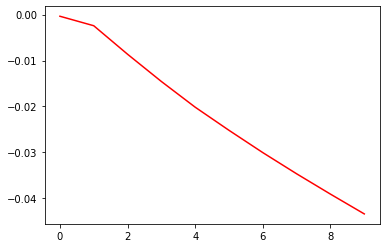

In [54]:
import matplotlib.pyplot as plt

epochs = range(0, int(N_EPOCHS))
plt.plot(epochs, casual_model_loss, 'r', label='Loss')

In [57]:
pred = predict(V, model, "tomorrow morning i will", 20)
print(pred)

['tomorrow', 'morning', 'i', 'will', 'tablebases', 'turing', 'ode', 'slurp', 'liat', 'contrasted', 'ayre', 'wulff', 'website', 'pollock', 'deprecation', 'thurmond', 'flavours', 'disarmament', 'dagestani', 'gurning', 'acrylics', 'singers', 'appendages', 'mesopotamia']


In [58]:
for sentence, target in entailment_pairs[:10]:
    answer = sentence2sentence(sentence)

    print('text: ', sentence, '\ntarget: ', target, '\nanswer: ', answer, '\n')

text:  there was no choice between warm and cold dishes on the train 
target:  diversity of food limited 
answer:  the the the the the the the the britain the the the  

text:  food is execrable 
target:  food was basically inedible 
answer:  the the the  

text:  the food is disgusting 
target:  food is awful 
answer:  the the the the  

text:  food was awful 
target:  food was basically inedible 
answer:  the the the  

text:  food in the undercroft bar was awful 
target:  the food is awful 
answer:  the the the the the the the  

text:  food is finished too early 
target:  food portions are small 
answer:  the the the the the  

text:  food could be with more choice 
target:  the food choices are limted 
answer:  the the the the the the  

text:  food is getting worse 
target:  food is less impressive than it used to be 
answer:  the the the the  

text:  tickets very expensive 
target:  selling cheaper tickets 
answer:  the the the  

text:  only comment i can make is the legroom 


In [ ]:
SAVE_PATH = "/content/drive/MyDrive/Colab Notebooks/torch_model"

In [ ]:
torch.save(model.state_dict(), SAVE_PATH)

https://pytorch.org/tutorials/beginner/saving_loading_models.html

## Model tuning

In [ ]:
"""N_EPOCHS = 10
BATCH_SIZE = 100
N_SAMPLES = 1000
SAMPLE_RATE = 1

tuning_model_loss = []
cos_sim_mean = []
n_nan = []

X = X_t[:N_SAMPLES]
y = y_t[:N_SAMPLES]

# split dataset into batches
X = [X[i:i + BATCH_SIZE] for i in range(0, len(X), BATCH_SIZE)]
y = [y[i:i + BATCH_SIZE] for i in range(0, len(y), BATCH_SIZE)]

for epoch in tqdm(range(N_EPOCHS)):
    for idx in range(len(X)):
        model.zero_grad()
        scores = model(X[idx])
        target = y[idx]
        loss = loss_function(scores.view(scores.shape[0] * scores.shape[1], -1) , torch.flatten(target))
        tuning_model_loss.append(loss)
        loss.backward()
        optimizer.step()"""

"""    if idx % SAMPLE_RATE == 0:
        mean_, n_nan_ = evaluate_model(entailment_pairs) # <----- sostituire con batched
        cos_sim_mean.append(mean_)
        n_nan.append(n_nan_)"""

In [ ]:
"""import matplotlib.pyplot as plt

epochs = range(0, int(N_EPOCHS/SAMPLE_RATE))
plt.plot(epochs, cos_sim_mean, 'g', label='Cosine similarity mean')"""
#plt.plot(epochs, n_nan, 'r', label='Missing answers')

In [ ]:
"""plt.plot(epochs, n_nan, 'r', label='Missing answers')"""